In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import zipfile
import requests
import random
import torchvision
from torchvision import models
from PIL import Image
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from typing import Dict, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
from torchmetrics import Accuracy


In [3]:
data_path= Path("Food/")
image_path= data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exist.")
else:
    image_path.mkdir(parents=True, exist_ok=True)

    
    
#Iturnign off this to sae time
with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('downloading data')
    f.write(request.content)
        
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print('Unzipping food data')
    zip_ref.extractall(image_path)

Food/pizza_steak_sushi already exist.
downloading data
Unzipping food data


In [4]:
#removing zip file
os.remove(data_path / "pizza_steak_sushi.zip")

In [5]:
#training and testing pth
train_dir=image_path/'train'
test_dir=image_path/'test'

In [6]:
train_dir, test_dir

(PosixPath('Food/pizza_steak_sushi/train'),
 PosixPath('Food/pizza_steak_sushi/test'))

Random Image Path: Food/pizza_steak_sushi/train/pizza/2800325.jpg
Image Class: pizza
Image Height: 512
Image Width: 512


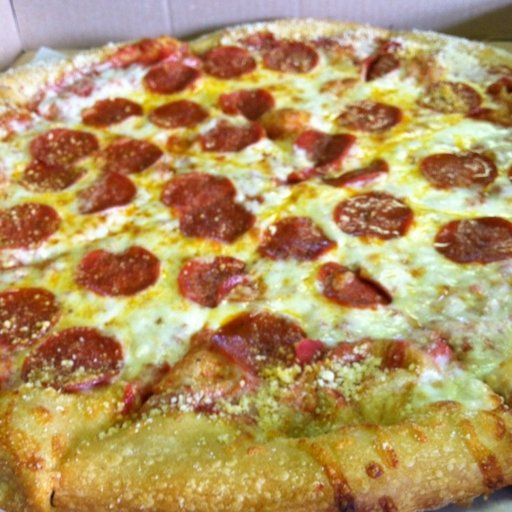

In [7]:
# Get all image paths 
image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

In [8]:
# Importing Dataset and Dataloader and augumenting

In [9]:
train_transform=transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(p=0.4),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.ColorJitter(brightness=0.2, contrast=1.5, saturation=0.5),
                                    transforms.RandomAffine(degrees=0, shear=10), 
                                    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                   ])

test_transform= transforms.Compose([transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                   ])



train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [10]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: Food/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.4)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.0, 2.5), saturation=(0.5, 1.5), hue=None)
               RandomAffine(degrees=[0.0, 0.0], shear=[-10.0, 10.0])
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [11]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: Food/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [12]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
print(f"Image datatype: {img.dtype}\n")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}\n")
print(f"Image tensor:\n{img}")

Image shape: torch.Size([3, 256, 256]) -> [color_channels, height, width]
Image datatype: torch.float32

Image label: 0
Label datatype: <class 'int'>

Image tensor:
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -

In [13]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
len(train_data), len(test_data)

(225, 75)

In [16]:
num_workers = os.cpu_count()
print(f"Number of available workers: {num_workers}")

Number of available workers: 4


In [17]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
Tesla P100-PCIE-16GB


In [18]:
if torch.cuda.is_available():
    print("GPU is available Using GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU instead.")


GPU is available Using GPU: Tesla P100-PCIE-16GB


In [19]:
device=torch.cuda.get_device_name(0)
device

'Tesla P100-PCIE-16GB'

In [20]:
num_workers=os.cpu_count()
num_workers

4

# Turrning Train and testing data into dataloaders# 

In [21]:
torch.manual_seed(42)
batch_size=8
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             drop_last=True,
                             shuffle=True)

test_dataloader= DataLoader(dataset=test_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e3808b7c880>,
 <torch.utils.data.dataloader.DataLoader at 0x7e3808b7de10>)

In [22]:
len(train_dataloader), len(test_dataloader)

(28, 10)

In [23]:
#checking
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8]))

In [24]:
#Checking all batch batchsize
for batch_idx, (img, label) in enumerate(train_dataloader):
    print(f"Batch {batch_idx}: Image shape = {img.shape}, Label shape = {label.shape}")
    label.shape


Batch 0: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 1: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 2: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 3: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 4: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 5: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 6: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 7: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 8: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 9: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 10: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Batch 11: Image shape = torch.Size([8, 3, 256, 256]), Label shape = torch.Size([8])
Ba

# TinnyVGG Model

In [25]:
class TinyVGG(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_bloc_1 = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
                                         nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=2, stride=2)
                                        )
        
        self.conv_bloc_2 = nn.Sequential(nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
                                         nn.ReLU(),
                                         nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2)
                                        )
        
        # Calculate the flattened size dynamically
        self._dummy_input = torch.randn(1, input_channels, 256, 256)
        self._conv_out_size = self._get_conv_output_size()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self._conv_out_size, out_features=output_shape))
    
    def _get_conv_output_size(self):
        """ Pass a dummy input through conv layers to compute the output size dynamically """
        with torch.no_grad():
            x = self.conv_bloc_1(self._dummy_input)
            x = self.conv_bloc_2(x)
        return x.numel()

    def forward(self, x: torch.Tensor):
        x = self.conv_bloc_1(x)
        x = self.conv_bloc_2(x)
        x = self.classifier(x)
        return x

In [26]:
torch.manual_seed(42)
model_1=TinyVGG(input_channels=3, hidden_units=10, output_shape=len(train_data.classes))
model_1

TinyVGG(
  (conv_bloc_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_bloc_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37210, out_features=3, bias=True)
  )
)

In [27]:
img_batch, batch_label=next(iter(train_dataloader))
img_single, label_single=img_batch[0].unsqueeze(dim=0), batch_label[0]
img_single.shape

torch.Size([1, 3, 256, 256])

In [28]:
model_1.eval()
with torch.inference_mode():
    pred=model_1(img_single)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[-0.0889, -0.0068, -0.0236]])

Output prediction probabilities:
tensor([[0.3172, 0.3443, 0.3386]])

Output prediction label:
tensor([1])

Actual label:
2


In [29]:
def train_step(model: torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer)-> Tuple[float, float]:
    model.train()
    train_loss, train_acc=0,0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        loss=loss_fn(y_pred, y)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss= train_loss/len(dataloader)
    train_acc= train_acc/len(dataloader)

    return train_loss, train_acc

In [30]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            test_pred_logits = model(X)

            loss=loss_fn(test_pred_logits, y)
            test_loss+=loss.item()

            test_pred_labels= test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)
    return test_loss, test_acc

In [31]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int)-> Dict[str, list[float]]:

    
    results={"train_loss": [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}
    
    for epoch in range(epochs):
        train_loss, train_acc= train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
                                          
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
                                          
        print(f"Epochs : {epoch+1} | "
              f"Train_loss : {train_loss :4f} | "
              f"Train_acc : {train_acc:.4f} | "
              f"Test_loss : {test_loss:.4f} | "
              f"Test_acc : {test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
                                          
    return results                                        

In [32]:
torch.manual_seed(42)

model_1 = TinyVGG(input_channels=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes))

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001, weight_decay=1e-4)


results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=7)

Epochs : 1 | Train_loss : 1.217222 | Train_acc : 0.3170 | Test_loss : 1.0537 | Test_acc : 0.4500
Epochs : 2 | Train_loss : 1.049966 | Train_acc : 0.4464 | Test_loss : 0.9712 | Test_acc : 0.4792
Epochs : 3 | Train_loss : 0.943376 | Train_acc : 0.5223 | Test_loss : 1.0457 | Test_acc : 0.4625
Epochs : 4 | Train_loss : 0.962354 | Train_acc : 0.5402 | Test_loss : 0.9884 | Test_acc : 0.4208
Epochs : 5 | Train_loss : 0.875280 | Train_acc : 0.5670 | Test_loss : 0.9980 | Test_acc : 0.4375
Epochs : 6 | Train_loss : 0.893856 | Train_acc : 0.5759 | Test_loss : 0.9441 | Test_acc : 0.4833
Epochs : 7 | Train_loss : 0.853451 | Train_acc : 0.5938 | Test_loss : 1.0030 | Test_acc : 0.4708


In [33]:
model_1_df = pd.DataFrame(results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.217222,0.316964,1.053734,0.450000
1,1.049966,0.446429,0.971245,0.479167
2,0.943376,0.522321,1.045729,0.462500
3,0.962354,0.540179,0.988369,0.420833
4,0.875280,0.566964,0.997962,0.437500
5,0.893856,0.575893,0.944069,0.483333
6,0.853451,0.593750,1.003023,0.470833


In [34]:
from torchinfo import summary 
summary(model_1, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 126, 126]         --
│    └─Conv2d: 2-1                       [1, 10, 254, 254]         280
│    └─ReLU: 2-2                         [1, 10, 254, 254]         --
│    └─Conv2d: 2-3                       [1, 10, 252, 252]         910
│    └─ReLU: 2-4                         [1, 10, 252, 252]         --
│    └─MaxPool2d: 2-5                    [1, 10, 126, 126]         --
├─Sequential: 1-2                        [1, 10, 61, 61]           --
│    └─Conv2d: 2-6                       [1, 10, 124, 124]         910
│    └─ReLU: 2-7                         [1, 10, 124, 124]         --
│    └─Conv2d: 2-8                       [1, 10, 122, 122]         910
│    └─ReLU: 2-9                         [1, 10, 122, 122]         --
│    └─MaxPool2d: 2-10                   [1, 10, 61, 61]           --
├─Sequentia

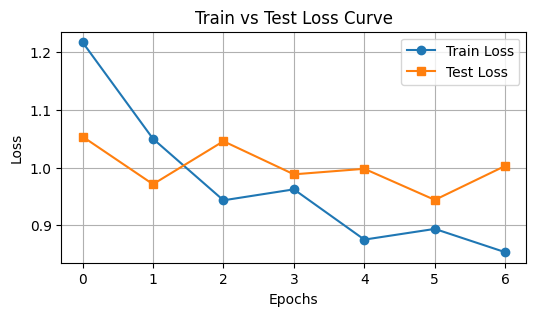

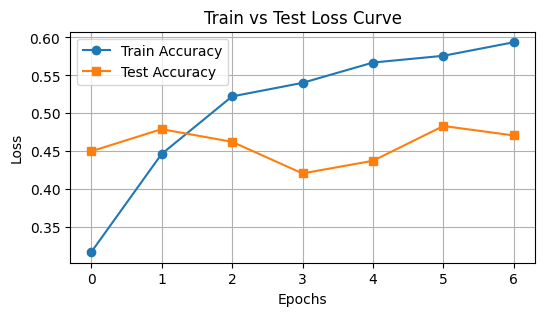

In [35]:
plt.figure(figsize=(6,3))
plt.plot(model_1_df["train_loss"], label="Train Loss", marker="o")
plt.plot(model_1_df["test_loss"], label="Test Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(6,3))
plt.plot(model_1_df["train_acc"], label="Train Accuracy", marker="o")
plt.plot(model_1_df["test_acc"], label="Test Accuracy", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Using Pretrained model

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
model= models.efficientnet_b0(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(model.classifier[1].in_features, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(256, len(class_names))
                                  )

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [38]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch = image_batch.to(device)
label_batch = label_batch.to(device)


image_batch.shape, label_batch.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8]))

In [39]:
len(train_dataloader), len(test_dataloader)

(28, 10)

In [40]:
model(image_batch)

tensor([[-0.2750, -0.3243, -1.3205],
        [ 0.3439,  0.3561, -0.0185],
        [ 0.3400,  0.2880, -0.4337],
        [-0.1343, -0.0199, -0.6057],
        [-0.1203, -0.2057, -0.0213],
        [ 0.5601,  0.0164,  0.1540],
        [ 0.6110,  0.0790, -0.3688],
        [-0.1157,  0.0100,  0.1327]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [41]:
# # Important Parameters
# lr = 0.001
# epochs=10

In [42]:
# Loss & Optimizers
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

In [43]:
def train_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,
               loss_function:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy,
               device:torch.device):
    
    train_loss, train_acc = 0,0
    model.train()

    #loop through training batch
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred.argmax(dim=1)).item()*100

        optimizer.zero_grad()
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [44]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              accuracy,
              device:torch.device):
    
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            test_pred = model(X)
            loss = loss_function(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred.argmax(dim=1)).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

In [45]:
def train(model: torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_function: torch.nn.Module,
          accuracy,
          scheduler,
          device:torch.device,
          epochs:int=10):

    model.to(device)

    # Result
    results = {'train_loss':[],
               'train_acc':[],
               'test_loss':[],
               'test_acc':[]
              }

    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        # Train step
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           accuracy=accuracy,
                                           device=device)

        # Test step
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_function=loss_function,
                                        accuracy=accuracy,
                                        device=device)

        print(f"Epochs : {epoch+1} |Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_acc:.2f}%")
        
        # Store results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # Reduce learning rate based on test loss (for ReduceLROnPlateau)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss)
        else:
            scheduler.step()

    return results

# Initialize accuracy
accuracy = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

# Train the model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_function=loss_function,
                      accuracy=accuracy,
                      scheduler=scheduler,
                      device=device,
                      epochs=5)

Epochs : 1 |Training Loss: 0.8080 | Training Accuracy: 66.07% | Testing Loss: 0.3220 | Testing Accuracy: 93.75%
Epochs : 2 |Training Loss: 0.5234 | Training Accuracy: 78.57% | Testing Loss: 0.3687 | Testing Accuracy: 87.50%
Epochs : 3 |Training Loss: 0.4481 | Training Accuracy: 84.38% | Testing Loss: 0.2531 | Testing Accuracy: 87.50%
Epochs : 4 |Training Loss: 0.3620 | Training Accuracy: 85.27% | Testing Loss: 0.3376 | Testing Accuracy: 88.75%
Epochs : 5 |Training Loss: 0.2993 | Training Accuracy: 89.73% | Testing Loss: 0.2647 | Testing Accuracy: 86.25%


In [46]:
model_df = pd.DataFrame(model_results)
model_df

,train_loss,train_acc,test_loss,test_acc
0,0.807979,66.071429,0.322040,93.75
1,0.523354,78.571429,0.368698,87.50
2,0.448146,84.375000,0.253071,87.50
3,0.361974,85.267857,0.337599,88.75
4,0.299285,89.732143,0.264737,86.25


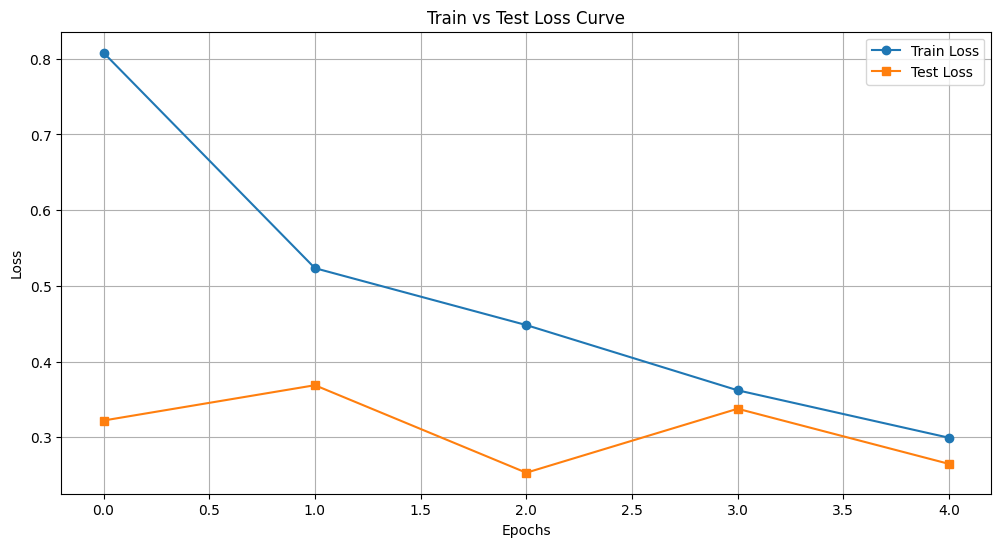

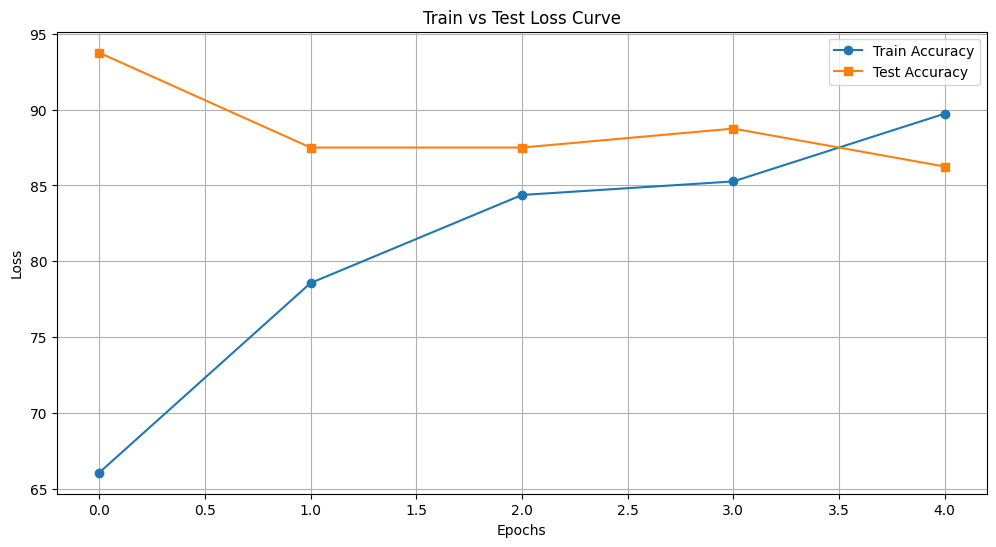

In [47]:
plt.figure(figsize=(12,6))
plt.plot(model_df["train_loss"], label="Train Loss", marker="o")
plt.plot(model_df["test_loss"], label="Test Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(12,6))
plt.plot(model_df["train_acc"], label="Train Accuracy", marker="o")
plt.plot(model_df["test_acc"], label="Test Accuracy", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Now Checking and verifying

In [48]:
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         64
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 16, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 16, 128, 128]         1,448
│    └─Sequential: 2-3                                  [1, 24, 64, 64]           --
│    │    └─MBConv: 3-5                                 [1, 24, 64, 64]           6,004
│    │    └─MBConv: 3-6                              

In [49]:
import requests

image_url = "https://api.pizzahut.io/v1/content/en-in/in-1/images/pizza/veggie-supreme.bc8dd369182b636ff171077efa53c344.1.jpg"
image_path = "/kaggle/working/sample.jpg"

# Download the image
response = requests.get(image_url)
if response.status_code == 200:
    with open(image_path, "wb") as file:
        file.write(response.content)
    print(f"Image downloaded successfully: {image_path}")
else:
    print("Failed to download image. Check the URL.")

Image downloaded successfully: /kaggle/working/sample.jpg


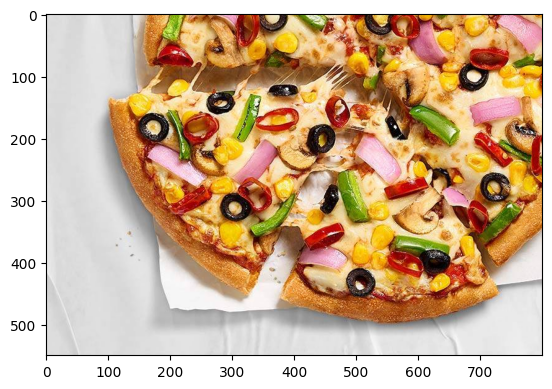

In [50]:
import matplotlib.pyplot as plt
import PIL.Image as Image
image = Image.open(image_path)
plt.imshow(image)
plt.show()

# Testing on downloaded data

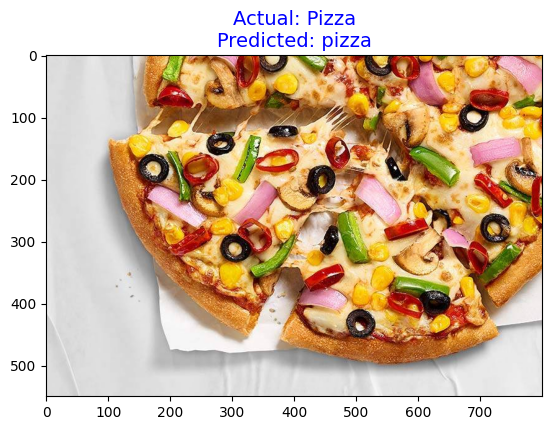

In [51]:
# Define image path
image_path = "/kaggle/working/sample.jpg"
actual_class = "Pizza" 

image = Image.open(image_path)
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                               ])

# Apply transformations
image_tensor = transform(image).unsqueeze(0)

# Move image device model
image_tensor = image_tensor.to(device)

#evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_label = class_names[predicted_class.item()]

# Display the image with labels
plt.imshow(Image.open(image_path))  # Load original for diplay
plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label}", fontsize=14, color="blue")
plt.show()


In [52]:

image_url_new = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRr2tr_5YsC25FCEyaNl7tnAxTChXJoTuK83w&s"
image_path_new = "/kaggle/working/sample_new.jpg"

# Download the image
response = requests.get(image_url_new)
if response.status_code == 200:
    with open(image_path_new, "wb") as file:
        file.write(response.content)
    print(f"Image downloaded successfully: {image_path_new}")
else:
    print("Failed to download image. Check the URL.")

Image downloaded successfully: /kaggle/working/sample_new.jpg


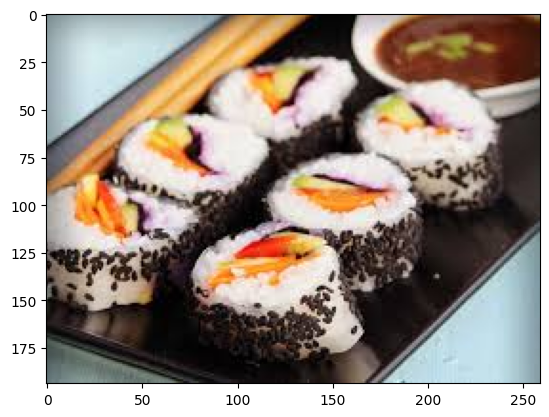

In [53]:
image_new = Image.open(image_path_new)
plt.imshow(image_new)
plt.show()

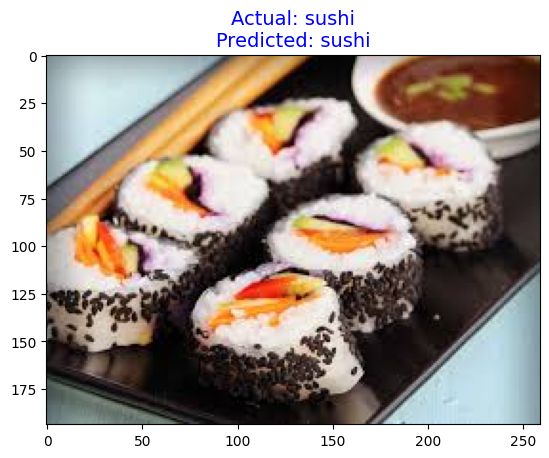

In [54]:
image_path_new = "/kaggle/working/sample_new.jpg"
actual_class_new = "sushi" 

image_new = Image.open(image_path_new)
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                               ])

image_tensor = transform(image_new).unsqueeze(0)
image_tensor = image_tensor.to(device)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_label = class_names[predicted_class.item()]

# Display the image with labels
plt.imshow(Image.open(image_path_new)) 
plt.title(f"Actual: {actual_class_new}\nPredicted: {predicted_label}", fontsize=14, color="blue")
plt.show()


In [55]:
summary(model_1, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 126, 126]         --
│    └─Conv2d: 2-1                       [1, 10, 254, 254]         280
│    └─ReLU: 2-2                         [1, 10, 254, 254]         --
│    └─Conv2d: 2-3                       [1, 10, 252, 252]         910
│    └─ReLU: 2-4                         [1, 10, 252, 252]         --
│    └─MaxPool2d: 2-5                    [1, 10, 126, 126]         --
├─Sequential: 1-2                        [1, 10, 61, 61]           --
│    └─Conv2d: 2-6                       [1, 10, 124, 124]         910
│    └─ReLU: 2-7                         [1, 10, 124, 124]         --
│    └─Conv2d: 2-8                       [1, 10, 122, 122]         910
│    └─ReLU: 2-9                         [1, 10, 122, 122]         --
│    └─MaxPool2d: 2-10                   [1, 10, 61, 61]           --
├─Sequentia

In [56]:
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         64
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 16, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 16, 128, 128]         1,448
│    └─Sequential: 2-3                                  [1, 24, 64, 64]           --
│    │    └─MBConv: 3-5                                 [1, 24, 64, 64]           6,004
│    │    └─MBConv: 3-6                              